In [1]:
using NBInclude

@nbinclude("julia_function.ipynb")

allskyevents_free_eres (generic function with 1 method)

In [2]:
# Defining oscillation probability function with distinct mass splitting values

function oscprobdistinct(et, dm21, dm22, dm23, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc1 = (cos((dm21 * leff)/(4*et*1e12)))^2
    osc2 = (cos((dm22 * leff)/(4*et*1e12)))^2
    osc3 = (cos((dm23 * leff)/(4*et*1e12)))^2

    prob_ee = osc1*(u[1]*u[1]) + osc2*(u[4]*u[4]) + osc3*(u[7]*u[7])
    prob_μe = osc1*(u[1]*u[2]) + osc2*(u[4]*u[5]) + osc3*(u[7]*u[8])

    prob_eτ = osc1*(u[3]*u[1]) + osc2*(u[6]*u[4]) + osc3*(u[9]*u[7])
    prob_μτ = osc1*(u[3]*u[2]) + osc2*(u[6]*u[5]) + osc3*(u[9]*u[8])

    prob_eμ = osc1*(u[2]*u[1]) + osc2*(u[5]*u[4]) + osc3*(u[8]*u[7])
    prob_μμ = osc1*(u[2]*u[2]) + osc2*(u[5]*u[5]) + osc3*(u[8]*u[8])

    prob_e = 0.333333prob_ee + 0.666666prob_μe
    prob_τ = 0.333333prob_eτ + 0.666666prob_μτ
    prob_μ = 0.333333prob_eμ + 0.666666prob_μμ

    # νμ contribution comes from the 25% chance of a neutral current interaction, which appears as a cascade
    prob_cascade = prob_e + prob_τ + 0.25prob_μ
end

oscprobdistinct (generic function with 1 method)

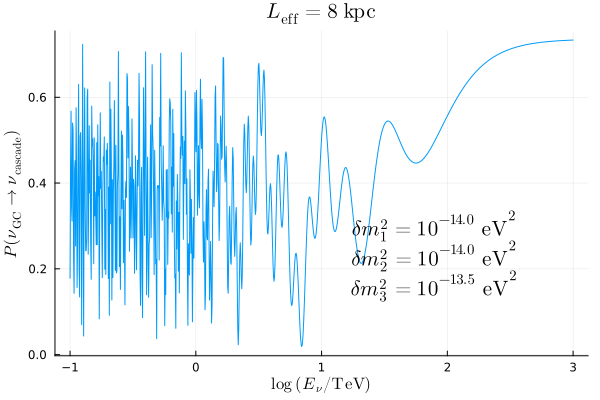

In [21]:
# Plotting the new oscillation probabilities

dm2s = (10^(-13.5), 10^(-13), 10^(-12.5))

leff = 8

us = range(-1, 3, 1000)
es = 10 .^ us

oscprobs = oscprobdistinct.(es, dm2s[1], dm2s[2], dm2s[3], leff)

plot(
    us,
    oscprobs,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{\mathrm{GC}} \to \nu_{\mathrm{cascade}})",
    ann=[(1.9, 0.3, L"\delta m_1^2 = 10^{-14.0}~\mathrm{eV}^2"), (1.9, 0.23, L"\delta m_2^2 = 10^{-14.0}~\mathrm{eV}^2"), (1.9, 0.16, L"\delta m_3^2 = 10^{-13.5}~\mathrm{eV}^2")],
    label=false,
    title=L"L_{\mathrm{eff}} = 8~\mathrm{kpc}"
)

In [26]:
# Redefining event distribution functions

function smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps)
    
    # Mutates emptymat and ur
    function fstrippedmat!(emptymat, ur, dm21, dm22, dm23, l, b, θ, ϕ₀, γ)
        ur .= 10 .^ ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)
        for i in 1:length(ur)
            for j in 1:length(rbins)
                vols = blength * oscprobdistinct(ur[i], dm21, dm22, dm23, rbins[j]) * sbinarea(rbins[j], l, b, θ)
                emptymat[j, i] = vols
            end 
        end
        flx = fluxfreeparams1(ur, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        vec(sum(flx .* emptymat, dims=1)) .* (effarea.(ur) * 10000)
    end

    # The -1 and 0.5 are sorta arbitrary constants that shift the function enough to provide correct results (hehe)
    samples = range(-1, log10(emax)+1, length=1000)
    de = samples[2]-samples[1]

    # Altered PDF from the Galactic plane paper
    pdf_func(ur) = @. log(10) * exp10(ur - 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func(samples)
    g_fft = fft(gsample)

    emptymat = zeros(61, length(samples)) # 61 from the sampling frequency along r
    fsample = fstrippedmat!(emptymat, collect(samples), dm21, dm22, dm23, l, b, θ, ϕ₀, γ)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de

    # Again shifting the function to fit with expectation
    cut = trunc(Int, (1)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))

    fg = Interpolations.interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinneddistinct (generic function with 1 method)

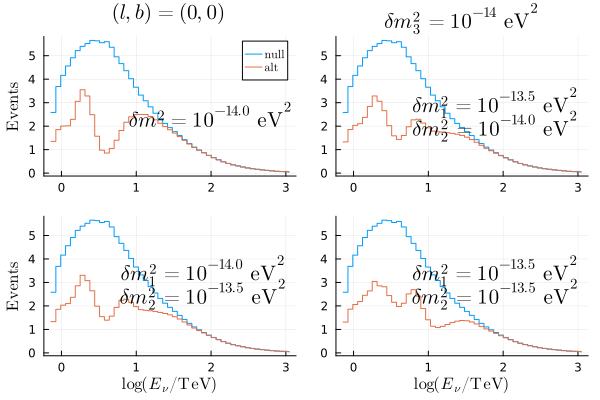

In [27]:
# Plotting the new event distributions

dm2s = (10^(-14), 10^(-14), 10^(-14))
dm2s1 = (10^(-13.5), 10^(-14), 10^(-14))
dm2s2 = (10^(-14), 10^(-13.5), 10^(-14))
dm2s3 = (10^(-13.5), 10^(-13.5), 10^(-14))

ubins = range(log10(emin), log10(emax), length=50)

distbins = edistbinneddistinct(dm2s[1], dm2s[2], dm2s[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins1 = edistbinneddistinct(dm2s1[1], dm2s1[2], dm2s1[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins2 = edistbinneddistinct(dm2s2[1], dm2s2[2], dm2s2[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins3 = edistbinneddistinct(dm2s3[1], dm2s3[2], dm2s3[3], 0, 0, 0.01, 0.122, 21.8, 2.7)


distbinsnull = edistbinneddistinct(0.0, 0.0, 0.0, 0, 0, 0.01, 0.122, 21.8, 2.7)

p0 = plot(
    ubins,
    [distbinsnull distbins],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"(l, b) = (0, 0)",
    ann=[(2, 2.5, L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2")]
)

p1 = plot(
    ubins,
    [distbinsnull distbins1],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    title=L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 2, L"\delta m_2^2 = 10^{-14.0}~\mathrm{eV}^2")]
)

p2 = plot(
    ubins,
    [distbinsnull distbins2],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    # title=L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3.5, L"\delta m_1^2 = 10^{-14.0}~\mathrm{eV}^2"), (1.9, 2.5, L"\delta m_2^2 = 10^{-13.5}~\mathrm{eV}^2")]
)

p3 = plot(
    ubins,
    [distbinsnull distbins3],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    # title=L"\delta m_2^2 = \delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3.5, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 2.5, L"\delta m_2^2 = 10^{-13.5}~\mathrm{eV}^2")]
)

plot(p0, p1, p2, p3, layout=(2, 2))

In [28]:
# Redefined the likelihood functions

function negloglhdistinct(dm21, dm22, dm23, l, b, θ, ϕ₀, γ, σ)

    nullhyp = edistbinneddistinct(0, 0, 0, l, b, σ, θ, 21.8, 2.7)
    althyp = edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end


function maxlhdistinct(dm21, dm22, dm23, l, b)

    θ = 0.122
    σ = 0.01

    function nllh(test)
        return negloglhdistinct(dm21, dm22, dm23, l, b, θ, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrtbinneddistinct(dm21, dm22, dm23, l, b)
    minim = maxlhdistinct(dm21, dm22, dm23, l, b)

    params = Optim.minimizer(minim)

    null = edistbinneddistinct(0, 0, 0, l, b, 0.01, 0.122, 21.8, 2.7)
    alt = edistbinneddistinct(dm21, dm22, dm23, l, b, 0.01, 0.122, params[1], params[2])

    ts = lrt(null, alt)
end

function maxlhdistinct_free_eres(dm21, dm22, dm23, l, b, σ)

    θ = 0.122

    function nllh(test)
        return negloglhdistinct(dm21, dm22, dm23, l, b, θ, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrtbinneddistinct_free_eres(dm21, dm22, dm23, l, b, σ)
    minim = maxlhdistinct_free_eres(dm21, dm22, dm23, l, b, σ)

    params = Optim.minimizer(minim)

    null = edistbinneddistinct(0, 0, 0, l, b, σ, 0.122, 21.8, 2.7)
    alt = edistbinneddistinct(dm21, dm22, dm23, l, b, σ, 0.122, params[1], params[2])

    ts = lrt(null, alt)
end

lrtbinneddistinct_free_eres (generic function with 1 method)

In [32]:
# Calculating sensitivities for different distinct mass splittings

logdm21s = range(-15, -13, 50)
logdm22s = range(-15, -13, 50)

dm21s = 10 .^ logdm21s
dm22s = 10 .^ logdm22s
dm23 = 10^(-14)

teststatsdistinct = [lrtbinneddistinct(dm21, dm22, dm23, 0, 0) for dm22 in dm22s, dm21 in dm21s]


50×50 Matrix{Float64}:
 0.614896  0.684842  0.775987  0.891039  …  0.795492  0.799844  0.790516
 0.679522  0.763331  0.871132  1.00585      0.788397  0.794875  0.787272
 0.762641  0.862985  0.990741  1.14916      0.793285  0.802199  0.79657
 0.866267  0.985976  1.13723   1.32373      0.81395   0.825609  0.822209
 0.989883  1.13161   1.30976   1.52865      0.85288   0.867562  0.86663
 1.12825   1.29383   1.50134   1.75596   …  0.909305  0.927211  0.928944
 1.26905   1.4585    1.69571   1.98689      0.976958  0.998143  1.00266
 1.39174   1.60202   1.86554   2.18974      1.04299   1.06729   1.07459
 1.47021   1.69419   1.97561   2.32317      1.09068   1.11765   1.12757
 1.48109   1.70747   1.99324   2.3482       1.10795   1.13686   1.14909
 1.41617   1.63099   1.90424   2.24654   …  1.0998    1.12968   1.14382
 1.29169   1.48112   1.72511   2.0347       1.09615   1.12595   1.14147
 1.14632   1.2995    1.50102   1.76199      1.14552   1.17417   1.19054
 ⋮                                   

In [1]:
# Saving the array

writedlm("misc_data/distinct_dm2_vals_001_res_new_pcasc_calc.txt", teststatsdistinct)

LoadError: UndefVarError: `writedlm` not defined

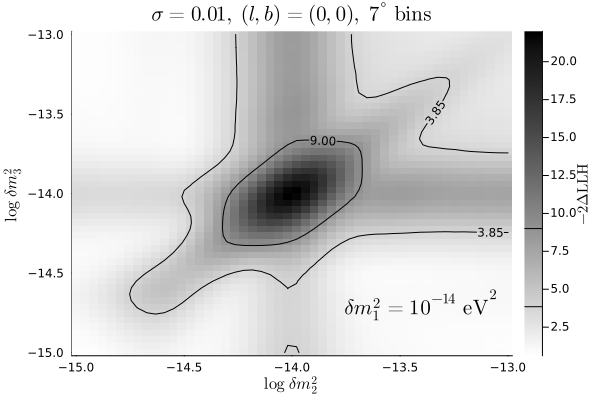

In [34]:
# Plotting the data

plot(
    logdm21s,
    logdm21s,
    teststatsdistinct,
    c=:grayC,
    xlabel=L"\log~\delta m_2^2",
    ylabel=L"\log~\delta m_3^2",
    colorbar_title=L"-2\Delta\mathrm{LLH}",
    title=L"\sigma = 0.01,~(l, b) = (0, 0),~7^{\circ}~\mathrm{bins}",
    ann=[(-13.4, -14.7, L"\delta m_1^2 = 10^{-14}~\mathrm{eV}^2")],
    seriestype=:heatmap,
    # interpolate=true
)

plot!(
    logdm21s,
    logdm21s,
    teststatsdistinct,
    levels=[3.85, 9.00],
    c=:black,
    clabels=true
)

In [92]:
# Saving the plot

# savefig("misc_plots/distinct_dm2_vals_001_res.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/distinct_dm2_vals_001_res.png"